In [22]:
import jax
import jax.numpy as jnp
import equinox as eqx

import numpy as np
import time

from history import History
from optimisers import train_step, resample_rad, JaxoptWrapper

import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [23]:
from problems import Poisson10D
problem = Poisson10D()

In [24]:
xs = np.random.rand(10)

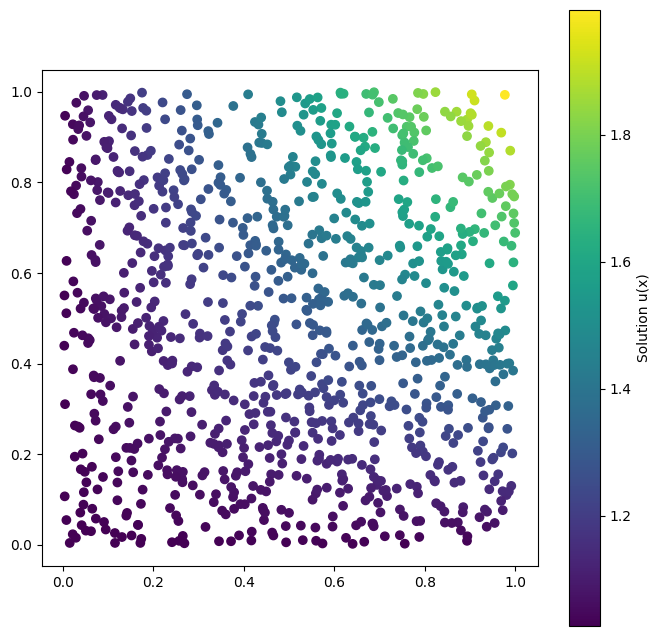

In [25]:
x, y = np.random.rand(2, 1000)
colors = [] # 1. Create a list to store the color values

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

for i in range(1000):
    test_xs = xs.copy()
    test_xs[0] = x[i]
    test_xs[1] = y[i]
    
    u = problem.exact_solution_point(test_xs)
    colors.append(u) # 2. Append the calculated value to the list

# 3. Call scatter ONCE with all the data
scatter = ax.scatter(x, y, c=colors)

# Optional: Add a color bar to understand the values
fig.colorbar(scatter, ax=ax, label="Solution u(x)")

plt.show()

In [26]:
key = jax.random.PRNGKey(42)

layer_sizes = [10, 20, 20, 20, 20, 1]

model_key, sample_key = jax.random.split(key, 2)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
model = eqx.combine(params, static) 

# --- Collocation points ---
resample_every_n_epochs = 50
rad_k = 1.0
rad_c = 1.0
n_collocation_points = 2**14
n_candidate_points = 20 * n_collocation_points
candidate_points = problem.get_candidate_points(n_candidate_points, seed=1)
collocation_points = resample_rad(
    model,
    candidate_points,
    n_collocation_points,
    problem,
    rad_k,
    rad_c,
    sample_key
)

import jaxopt

history = History()


<function matplotlib.pyplot.show(close=None, block=None)>

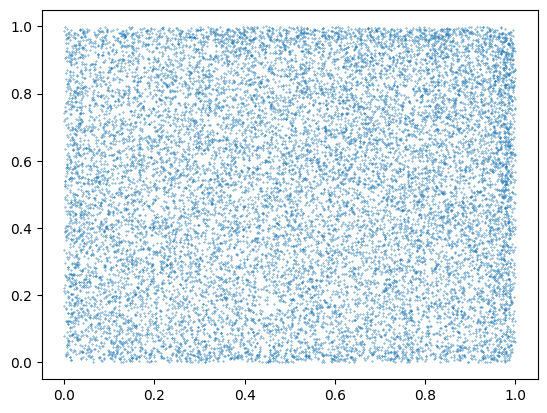

In [27]:
plt.scatter(collocation_points[:, 0], collocation_points[:, 1], s=0.1)
plt.show

In [28]:
epoch = 0
total_train_step_time = 0

In [29]:
test_points = problem.get_candidate_points(10000, seed=1)
u_solution = problem.exact_solution_batch(test_points)

In [30]:
print(test_points.shape)
print(u_solution.shape)

print(u_solution[:20])
# print(u_pred[:20])


(10000, 10)
(10000,)
[1.0474005  0.72504866 1.2808502  1.4422609  0.95704335 1.8146869
 1.5281535  0.7990129  0.9720365  1.5313993  0.9322789  1.4907877
 1.324173   0.88306653 1.0524468  1.1235669  0.78254133 1.3799874
 1.0096097  0.77279896]


In [31]:
for _ in range(5):

    def loss_fn(params, static, residual_fn):
        model = eqx.combine(params, static)
        residuals = jax.vmap(lambda point: residual_fn(model, point))(collocation_points)
        return jnp.mean(residuals**2)

    start_train_step_time = time.monotonic()
    solver = jaxopt.ScipyMinimize(
        fun=lambda p: loss_fn(p, static, problem.physics_residual), 
        method="BFGS"
    )
    results = solver.run(params)
    end_train_step_time = time.monotonic()
    
    total_train_step_time += (end_train_step_time - start_train_step_time)
    
    params = results.params
    final_loss = results.state.fun_val
    
    # Print and record
    model = eqx.combine(params, static)
    u_pred = model.predict(test_points)
    error = np.abs(u_solution - u_pred)
    rel_l2_error = np.linalg.norm(error) / np.linalg.norm(u_solution)

    print(final_loss)
    print(f"{rel_l2_error:.3e}", f"{total_train_step_time:.3f}")

    metrics = {}
    
    metrics["rell2error"] = rel_l2_error
    metrics["time"] = total_train_step_time
    metrics["loss"] = final_loss

    history.record(metrics)

    sample_key, subkey = jax.random.split(sample_key, 2)
    collocation_points = resample_rad(
        model, 
        candidate_points, 
        n_collocation_points, 
        problem,
        rad_k,
        rad_c,
        subkey
    )

    epoch += 1

model = eqx.combine(params, static)
print("Training complete.")


0.8071052
4.348e-04 126.909
0.023403157
6.587e-05 222.073
0.043332864
6.587e-05 246.267
0.044254277
6.551e-05 261.347
0.04558752
6.524e-05 273.561
Training complete.


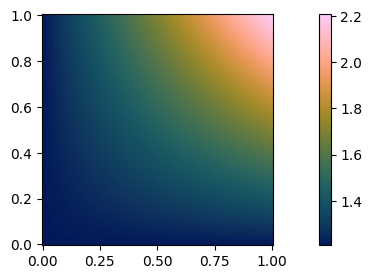

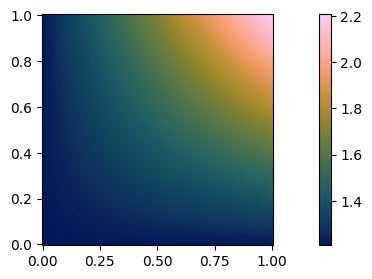

Relative L2 Error: 6.427e-05


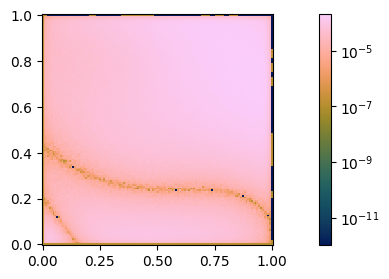

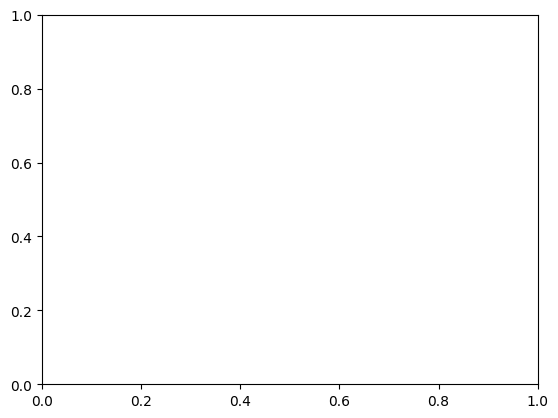

In [32]:
x, y = np.random.rand(2, 1000)

colors = [] # 1. Create a list to store the color values

X, Y = np.meshgrid(np.linspace(0, 1, 128), np.linspace(0, 1, 128))

xs = [0.0, 0.0, 0.64, 0.39, 0.80, 0.85, 0.52, 0.10, 0.48, 0.47]

@np.vectorize()
def get_u(x, y):
    test_xs = xs.copy()
    test_xs[0] = x
    test_xs[1] = y
    u = problem.exact_solution_point(test_xs)
    return u

U = get_u(X, Y)

inputs = np.tile(xs, (128*128, 1))
inputs[:, 0] = X.flatten()
inputs[:, 1] = Y.flatten()
predictions = model.predict(jnp.array(inputs))
U_pred = predictions.reshape(X.shape)


fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_sol = ax.pcolormesh(X, Y, U, cmap=cmap)
fig.colorbar(ax_sol, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, Y, U_pred, cmap=cmap)
fig.colorbar(ax_nn, ax=ax, pad=0.05)
plt.show()


error = np.abs(U - U_pred)
rel_l2_error = np.linalg.norm(error) / np.linalg.norm(U)
print(f"Relative L2 Error: {rel_l2_error:.3e}")


norm = mplcolors.LogNorm(vmin=error.min() + 1e-12, vmax=error.max())
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, Y, np.abs(error) + 1e-12, norm=norm, cmap=cmap)
fig.colorbar(nn_error, ax=ax, pad=0.05)
plt.show()

fig, ax = plt.subplots()
plt.show()

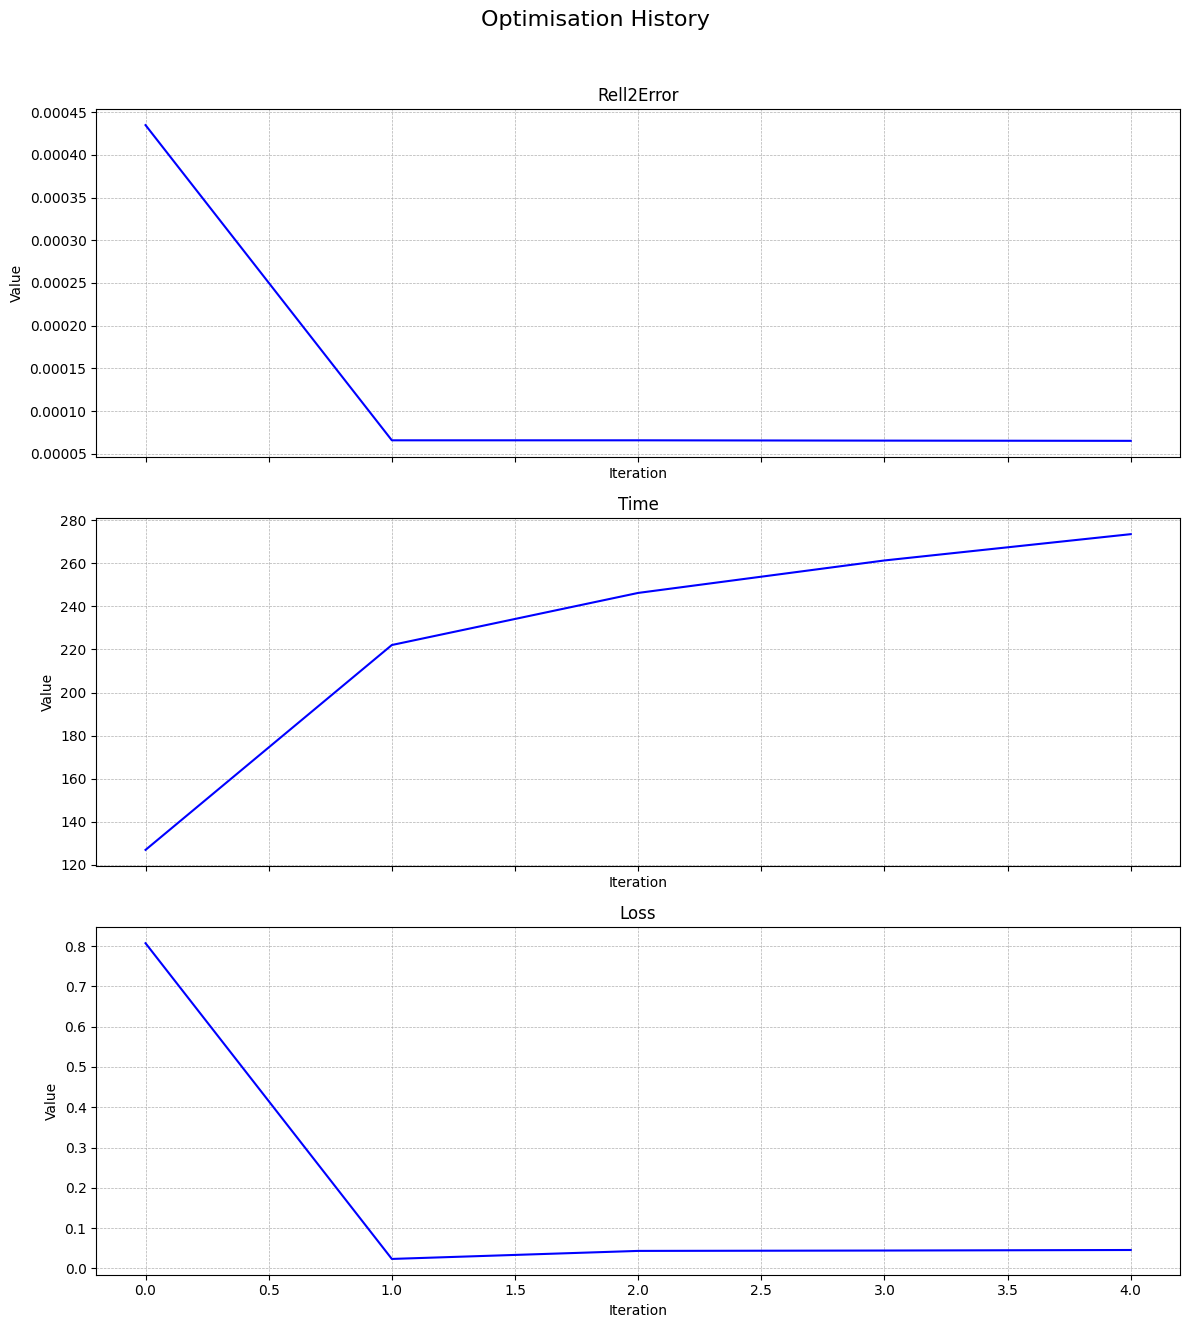

In [33]:
history.plot()

In [34]:
import scienceplots

plt.style.use(['science', 'no-latex'])

In [35]:
folder="experiments/10d-poisson/results"

In [36]:
np.save(folder+'/bfgs_u_pred.npy',           U_pred)

In [37]:
lm_l2err = history.history["rell2error"][:5]
lm_loss = history.history["loss"][:5]
# lm_lambda = history.history["lambda"][:5]
# lm_searchdirnorm = history.history["search_direction_norm"][:5]
# lm_svs = history.history["singular_values"][:5]
lm_time = history.history["time"][:5]

np.save(folder+'/bfgs_time.npy',              lm_time)
np.save(folder+'/bfgs_l2err.npy',             lm_l2err)
np.save(folder+'/bfgs_loss.npy',              lm_loss)
# np.save(folder+'/bfgs_lambda.npy',            lm_lambda)
# np.save(folder+'/bfgs_searchdirnorm.npy',     lm_searchdirnorm)
# np.save(folder+'/bfgs_svs.npy',               lm_svs)
# np.save(folder+'/bfgs_u_pred.npy',            u_pred)
# np.save(folder+'/bfgs_u_solution.npy',        u_solution)
# np.save('lm_X.npy',                 X)
# np.save('lm_T.npy',                 T)


In [38]:
print(np.min(burgerslm_l2err))

print(burgerslm_l2err[-1])

NameError: name 'burgerslm_l2err' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

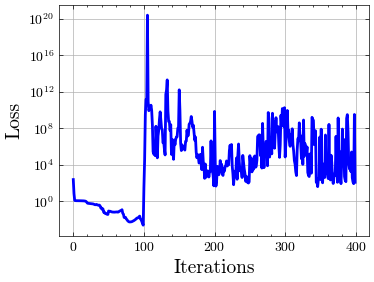

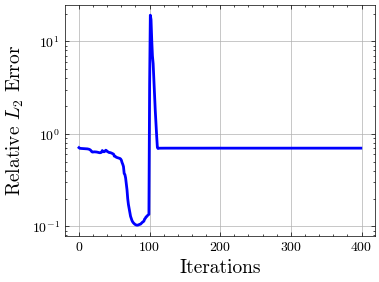

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(burgerslm_loss, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Loss', fontsize=14)
plt.grid()
plt.show

plt.figure(figsize=(4, 3))
plt.plot(burgerslm_l2err, color='b', linestyle='-', linewidth=2)
plt.yscale('log')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel(r'Relative $L_2$ Error', fontsize=14)
plt.grid()
plt.show

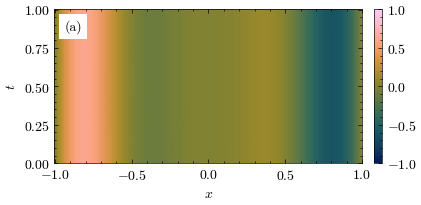

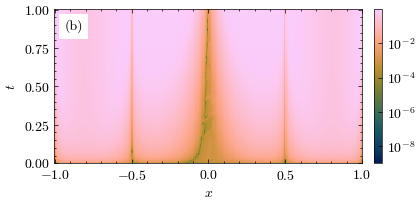

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
ax_nn = ax.pcolormesh(X, T, u_pred, cmap=cmap, rasterized=True,
                      vmin=-1,vmax=1)
fig.colorbar(ax_nn, ax=ax, pad=0.03)
ax.annotate("(a)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm.pdf", format="pdf")
plt.show()

norm = colors.LogNorm(vmin=error.min() + 1e-9, vmax=error.max())
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_aspect("equal")
nn_error = ax.pcolormesh(X, T, np.abs(error) + 1e-9, norm=norm, cmap=cmap, rasterized=True,)
fig.colorbar(nn_error, ax=ax, pad=0.03)
ax.annotate("(b)", xy=(0, 1), xycoords='axes fraction',
            xytext=(7, -7), textcoords='offset points',
            ha='left', va='top',
            bbox=dict(facecolor='white', alpha=1.0, linewidth=0))
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.savefig("burgers_lm_err.pdf", format="pdf")
plt.show()